In [0]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn.metrics
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##ORIE 5750 - Homework 1

###Maxwell Wulff mcw232 , Konstantinos Ntalis kn442 


###Problem 1: Digit Recognizer

###a)

In [0]:
train = pd.read_csv("/content/drive/My Drive/AML - Fall 2019/train (1).csv")
test = pd.read_csv("/content/drive/My Drive/AML - Fall 2019/test (1).csv")


###b) We create a function to display a digit  

In [0]:
def MNISTdigit(rowindex):
  img = np.array(train.iloc[rowindex,1:]).reshape(-1,28)
  plt.imshow(img, cmap = 'Greys')
  plt.show()

###and we print the first instance of every digit in the training set

In [0]:
for i in range(0,10):
  row = 0
  while train.iloc[row,0] != i:
    row += 1
  MNISTdigit(row)  
  

###c) We use the value_counts function to get the normalized count of each digit and plot the corresponding histogram

Text(0.5, 1.0, 'Normalized histogram of digit counts')

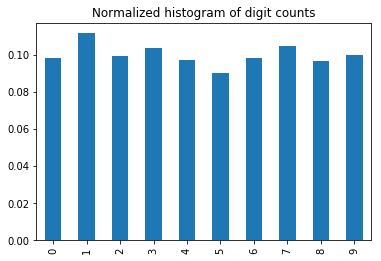

In [6]:
train['label'].value_counts(sort = False , normalize = True).plot('bar', )
plt.title('Normalized histogram of digit counts')

### It is relatively even, with the digit 5 being the most infrequent and 1 the most frequent.

###d) We start by getting the index of the first instance of each digit

In [0]:
 index = []
for i in range(0,10):
  row = 0
  while train.iloc[row,0] != i:
    row += 1
  index.append(row)


###Then, for each digit calculate the euclidean distance between itself and the rest of the training data. Choose the second value to exclude itself

In [0]:
train_array = train.to_numpy()
nearest = []

for i in index:
  l2_dist = np.argsort(((train_array[i,1:] - train_array[:,1:])**2).sum(-1))
  nearest.append(l2_dist[1]) 

In [9]:
nearestlabel = []
#for each digit, get the label of its nearest neighbor
for i in nearest:
  nearestlabel.append(train.iloc[i,0])

indexdf = pd.DataFrame(index)
nearestdf = pd.DataFrame(nearest)
nearestlabeldf = pd.DataFrame(nearestlabel)

#create table to compare original digits to nearest neighbor
out = np.transpose(pd.concat([np.transpose(indexdf), np.transpose(nearestdf), np.transpose(nearestlabeldf)]))  
out.columns = ["original index" , "nearest index", "nearest label"]

print(out)

   original index  nearest index  nearest label
0               1          12950              0
1               0          29704              1
2              16           9536              2
3               7           8981              5
4               3          14787              4
5               8          30073              5
6              21          16240              6
7               6          15275              7
8              10          32586              8
9              11          35742              9


###Our Number 3's closest neighbor is a Number 5. Other than that every other's nearest neighbor was itself.

###e)

In [0]:
#get and store just the zeros and ones from the training data
zeros = train[train.iloc[:,0] == 0]
ones = train[train.iloc[:,0] == 1]

#row bind these two to create one large dataframe
zo = pd.concat([zeros, ones])
zo = zo.to_numpy()
zo = zo[:,1:]

In [0]:
#calculate the pairwise distances for the above
dis = sklearn.metrics.pairwise.euclidean_distances(zo)

In [0]:
#use the size of each of the ones and zeros to pull the upper left
#and bottom right of the matrix (genuine 0 and genuine 1 respectively).
#flatten.
genzero = np.ndarray.flatten(dis[:zeros.shape[0],:zeros.shape[0]])
genone = np.ndarray.flatten(dis[zeros.shape[0]:,zeros.shape[0]:])

#use the size of each of the ones and zeros to pull the upper right
#and bottom left of the matrix (imposter matches).
#flatten.
imposterbl = np.ndarray.flatten(dis[zeros.shape[0]:,:zeros.shape[0]])
imposterur = np.ndarray.flatten(dis[:zeros.shape[0],zeros.shape[0]:])

#bind all of the genuine and imposter distances together
gen = np.hstack([genzero,genone])
imp = np.hstack([imposterbl, imposterur])


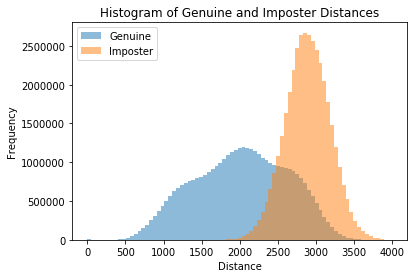

In [13]:
#plot the genuine and imposter distances on the same plot
bins = np.linspace(0, 4000, 80)

plt.hist(gen, bins, alpha = 0.5, label = 'Genuine')
plt.hist(imp, bins, alpha = 0.5, label = 'Imposter')
plt.legend(loc = 'upper left')
plt.title('Histogram of Genuine and Imposter Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()

###f)

In [0]:
#use zero to mark genuine matches
markg = np.zeros(gen.shape)

#use one to mark imposter matches
marki = np.ones(imp.shape)

In [0]:
#create two master vectors of distances and corresponding labels
dist = np.hstack([gen, imp])
mark = np.hstack([markg, marki])

In [0]:
#use sklearn's roc_curve() to calculate the roc curve
fpr, tpr, threshold = sklearn.metrics.roc_curve(mark, dist)

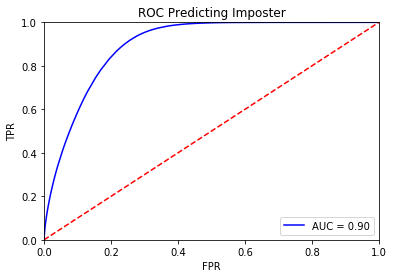

In [19]:
#plot ROC curve with AUC
roc_auc = sklearn.metrics.auc(fpr, tpr)


plt.title('ROC Predicting Imposter')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [23]:
EER_fpr = fpr[np.nanargmin(np.absolute(((1-tpr) - fpr)))]
EER_tpr = tpr[np.nanargmin(np.absolute(((1-tpr) - fpr)))]
print(EER_fpr, EER_tpr)


0.18554784422124979 0.814452073876342


In [68]:
print('The error of a classifier that simply guesses randomly is 50%')

The error of a classifier that simply guesses randomly is 50%


###g)

In [0]:
#create function to run KNN. take in a training set, test set, and k.
#output 3 arrays: (1) the actual labels (2) the nearest distances
#(3) the labels of the nearest neighbors

#trainSet includes the label in the first column
#testSet does not include the first column
def KNNtrain(trainSet, testSet, k):
  nearest = np.zeros((testSet.shape[0],k))
  nearestlabels = np.zeros((testSet.shape[0],k))
  
  
  for i in range(testSet.shape[0]):
    l2_dist = np.argsort(((testSet[i,:] - trainSet[:,1:])**2).sum(-1))
    nearest[i,:] = l2_dist[0:k]
  
  for i in range(nearest.shape[0]):
    for j in range(nearest.shape[1]):
      nearestlabels[i,j] = trainSet[int(nearest[i,j]),0]
  
  
  return(nearest, nearestlabels)

In [0]:
#split training set into two halves
trainSet = train.sample(frac = 0.5, random_state = 200)
testSet = train.drop(trainSet.index)

trainSet = trainSet.to_numpy()


testSet = testSet.to_numpy()
testActual = testSet[:,0]
testSet = testSet[:,1:]



In [0]:
#run the knn algorithm on the prior created training and test sets
neighbor, labels = KNNtrain(trainSet, testSet, k = 5)

In [0]:
#make a prediction based on the majority vote k nearest neighbors
def KNNPred(labels):
  
  prediction = np.zeros(labels.shape[0])
  for i in range(labels.shape[0]):
    vote = stats.mode(labels[i,:])[0][0]
    prediction[i] = vote
  return prediction

###h) We now train the k-NN classifier on the first half of the data, and test it on the second half, reporting our average accuracy.

In [0]:
#run on knn model created from test and training datasets
prediction = KNNPred(labels)

In [0]:
from sklearn.metrics import confusion_matrix

#build confusion matrix from prediction and actual of test set
cm = confusion_matrix(testActual, prediction)
acc = np.trace(cm)/np.sum(cm)
acc*100


96.11428571428571

###i) 10x10 confusion matrix

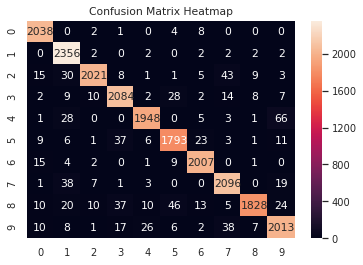

In [0]:
import seaborn as sns
sns.set(font_scale = 0.9)
conf_map = sns.heatmap(cm, annot = True, fmt='d')
conf_map.set_title('Confusion Matrix Heatmap')
plt.show()

###j) Training the classifier with all of the training data, and testing with the test data.

In [0]:
train = train.to_numpy()
test = test.to_numpy()


neighbor_final, labels_final = KNNtrain(train, test, k = 5)
Label = KNNPred(labels_final)

In [0]:
ImageId = range(1, len(Label)+1)
submit = pd.DataFrame({'ImageId': ImageId, 'Label': Label}, columns=['ImageId', 'Label'])
submit.to_csv('submission_digit.csv', index = False)

##2) The Titanic Disaster

###a)

In [0]:
train = pd.read_csv("/content/drive/My Drive/train_titanic.csv")
test = pd.read_csv("/content/drive/My Drive/test_titanic.csv")

###b) Before we fit logistic regression, we should first make sure that the dataset does not have missing values

In [44]:
#Checking for missing entries in the training set
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

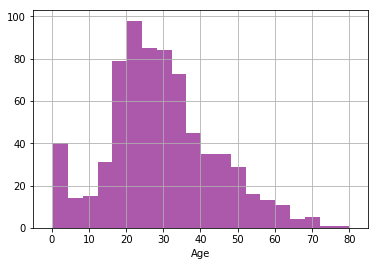

In [45]:
axs = train["Age"].hist(bins = 20, color = 'purple', alpha = 0.65)
axs.set(xlabel='Age')
plt.xlim(-5,85)
plt.show()

### Percent of missing values for the three categories (Age, Cabin, Embarked)

In [46]:
print('Percent of "Age" values that are missing: %.1f' %((train["Age"].isnull().sum()/train["Age"].shape[0])*100))
print('Percent of "Cabin" values that are missing: %.1f' %((train["Cabin"].isnull().sum()/train["Cabin"].shape[0])*100))
print('Percent of "Embarked" values that are missing: %.1f' %((train["Embarked"].isnull().sum()/train["Embarked"].shape[0])*100))

Percent of "Age" values that are missing: 19.9
Percent of "Cabin" values that are missing: 77.1
Percent of "Embarked" values that are missing: 0.2


###Since most of the "Cabin" values are missing (77%), we can drop this feature completely.

In [47]:
print('The mean of "Age" is %.2f' %(train["Age"].mean(skipna = True)))
print('The median of "Age" is %.2f' %(train["Age"].median(skipna = True)))


The mean of "Age" is 29.70
The median of "Age" is 28.00


###We can use the median to impute the missing Age values, since from the graph above, it seems that the Age distribution is right-skewed. For the "Embarked" feature we just use the most common observation to fill out the missing values.

In [0]:
train_imputed = train.copy()
train_imputed["Age"].fillna(train["Age"].median(skipna = True), inplace = True)
train_imputed["Embarked"].fillna(train['Embarked'].value_counts().idxmax(), inplace = True)
train_imputed.drop('Cabin', axis = 1, inplace = True)

###We can now produce some bar plots to study the relation between features and the response

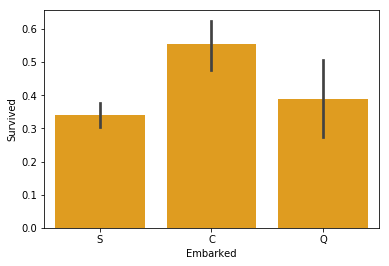

<function matplotlib.pyplot.show>

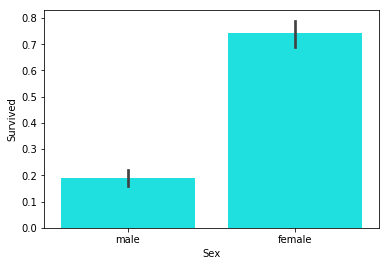

In [57]:
import seaborn as sns

sns.barplot('Embarked', 'Survived', data = train_imputed, color = "orange")
plt.show()

sns.barplot('Sex', 'Survived', data = train_imputed, color = "aqua")
plt.show

###We must apply the same steps to the test set, so that the two sets have the same structure. Furthermore, the 1 missing "Fare" value is completed using the median.

In [58]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [0]:
test_imputed = test.copy()
test_imputed["Age"].fillna(test["Age"].median(skipna = True), inplace = True)
test_imputed["Embarked"].fillna(train['Embarked'].value_counts().idxmax(), inplace = True)
test_imputed.drop('Cabin', axis = 1, inplace=True)

###Dropping variables

In [0]:
train_imputed.drop('Name', axis = 1, inplace = True)
train_imputed.drop('Ticket', axis = 1 , inplace = True)
train_imputed.drop('PassengerId', axis = 1 , inplace = True)

train_imputed = pd.get_dummies(train_imputed, columns = ['Pclass','Sex','Embarked'], drop_first = True)


###We combine 'SibSp' and 'Parch' to the new binary 'Alone' variable (0 if travelling alone and 1 if not).

In [0]:
train_imputed['Alone'] = np.ceil((train_imputed['SibSp'] + train_imputed['Parch'])/2).astype(object)
train_imputed.drop('SibSp', axis = 1, inplace = True)
train_imputed.drop('Parch', axis = 1, inplace = True)

In [0]:
test_imputed.drop('Name', axis = 1, inplace = True)
test_imputed.drop('Ticket', axis = 1 , inplace = True)
test_imputed.drop('PassengerId', axis = 1 , inplace = True)



###Create dummy variables for the three categorical features, so we can fit the regression model. We further drop the first column of each new dummy variable to deal with potential collinearity issues.

In [0]:
test_imputed = pd.get_dummies(test_imputed, columns = ['Pclass','Sex','Embarked'], drop_first = True)

In [64]:
test_imputed['Alone'] = np.ceil((test_imputed['SibSp'] + test_imputed['Parch'])/2).astype(object)
test_imputed.drop('SibSp', axis = 1, inplace = True)
test_imputed.drop('Parch', axis = 1, inplace = True)
test_imputed.head()

,Age,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,Alone
0,34.5,7.8292,0,1,1,1,0,0
1,47.0,7.0000,0,1,0,0,1,1
2,62.0,9.6875,1,0,1,1,0,0
3,27.0,8.6625,0,1,1,0,1,0
4,22.0,12.2875,0,1,0,0,1,1


In [65]:
test_imputed["Fare"].fillna(test["Fare"].mean(skipna = True), inplace = True)
test_imputed.isnull().sum()

Age           0
Fare          0
Pclass_2      0
Pclass_3      0
Sex_male      0
Embarked_Q    0
Embarked_S    0
Alone         0
dtype: int64

###Some more exploratory plots

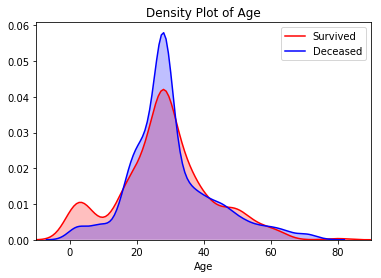

In [66]:
age_plot = sns.kdeplot(train_imputed["Age"][train_imputed.Survived == 1], color="red", shade = True)
sns.kdeplot(train_imputed["Age"][train_imputed.Survived == 0], color="blue", shade = True)
plt.legend(['Survived', 'Deceased'])
plt.title('Density Plot of Age')
age_plot.set(xlabel='Age')
plt.xlim(-10,90)
plt.show()

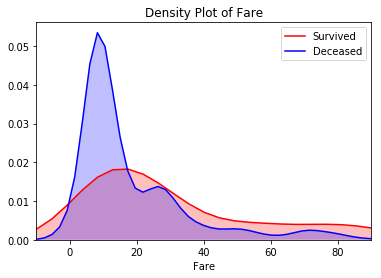

In [67]:
fare_plot = sns.kdeplot(train_imputed["Fare"][train_imputed.Survived == 1], color="red", shade = True)
sns.kdeplot(train_imputed["Fare"][train_imputed.Survived == 0], color="blue", shade = True)
plt.legend(['Survived', 'Deceased'])
plt.title('Density Plot of Fare')
fare_plot.set(xlabel='Fare')
plt.xlim(-10,90)
plt.show()

### c) Fitting Logistic Regression with all the training data

In [43]:
from sklearn import linear_model

x = train_imputed[['Age', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Alone']]
y = train_imputed['Survived']

lr = linear_model.LogisticRegression()
lr.fit(x, y)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
from sklearn import metrics
cm = metrics.confusion_matrix(y, lr.predict(x))
acc = np.trace(cm)/cm.sum()
print('Accuracy of the model is: %.1f' % (acc*100))

Accuracy of the model is: 80.2


### Making the final prediction on the test set

In [0]:
from sklearn import metrics
final_pred = lr.predict(test_imputed)
final_pred
submission = test[['PassengerId']]
submission['Survived'] = pd.Series(final_pred)
submission.to_csv('submission.csv', index = False)


##Written Exercises

###1) 

\begin{align}
Var[X-Y] = & E[(X-Y)^2]-E[X-Y]^2 \\
= & E[X^2-2XY+Y^2] - E[X-Y]^2 \\
=& E[X^2]-2E[XY]+E[Y^2] - E[X-Y]^2 \hspace{0.3cm}\text{by linearity of expectation} \\
= & E[X^2] -2E[XY] + E[Y^2] - E[X-Y]E[X-Y] \\
= & E[X^2] -2E[XY] + E[Y^2] - E[X]^2-E[Y]^2+2E[X]E[Y] \\
= & (E[X^2]-E[X]^2) + (E[Y^2]-E[Y]^2) -2E[XY] +2E[X]E[Y] \\
= & Var[X]+Var[Y] - 2*Cov[X,Y]
\end{align}

###2)

$P(Pos | Def) = .95$

$P(Neg | Good) = .95$

$P(Def) = .00001$

### 2a)

\begin{align}
P(Def | Pos) =& \frac{P(Pos|Def)P(Def)}{P(Pos|Def)P(Def)+P(Pos|Good)P(Good)} \\ =&  \frac{.95(.00001)}{.95(.00001)+.05(.99999)} \\ =&.00019
\end{align}


###2b)

Total Good: 9999900

Total Bad: 100

Good Thrown Away = $P(Pos|Good)*$Total Good
= 499995

Bad Shipped = $P(Neg|Bad)*$Total Bad = 5

### 3a) 

Let's first consider the boundary cases. When $k = 1$, since $(x_i,y_i)$ is included, then the the prediction error would be zero. When $k = n$, everything is included and since the classes are balanced, we would have 50% chance getting it right. As we vary $k$ from $n$ to $1$, the $0-1$ prediction error on the training data will, although not smoothly, almost monotonically decrease. As we gradually increase the complexity of our model, the bias decreases while the variance increases. We therefore expect our classifier to overfit on the training set, reaching a perfect prediction rate when $k=1$.

###3b)
As $k$ varies from $1$ to $n$ the validation error will first decrease and then increase again. This is because total error is a combination of the bias and variance. As $k$ increases the bias of the fit also incrases, however the variance goes down. The lowest total error will occur at the minimum of the combination of the two.

###3c)
To avoid this you could weight each neighbor's vote based on how far they are from the point. The closer the neighbor is the more their vote could count.

![](https://https://drive.google.com/drive/u/0/folders/1Hb0yEVT8ioWHMPGZvoYKEgUjOKKnzk4_)

###3d) 

Memory constraints can occur here. If we are working in a high dimension, then the storage of large vectors and the calculation of the distance matrix can be very computationaly expensive. Secondly, the curse of dimensionality can play a big role. Suppose that we have so many features, that inevitably some of them are irrelevant for the classification problem. Suppose further that we're trying to predict whether an individual will develop heart disease. If, apart from the BMI and the blood pressure, we include much more irrelevant features, such as their shoe size and their income, then two observations that would be close in two dimensions (using BMI and blood pressure) can suddenly appear to be very far apart in a higher dimensional space.

###3ei)

In [0]:
log_train = pd.DataFrame([[6,3] , [3,8]], columns = ['true red' , 'true blue'],
                        index = ['predicted red' , 'predicted blue'])

log_test = pd.DataFrame([[3,1] , [2,4]], columns = ['true red' , 'true blue'],
                        index = ['predicted red' , 'predicted blue'])

log_train_acc = (log_train.iloc[0,0] + log_train.iloc[1,1])/log_train.to_numpy().sum()
log_test_acc = (log_test.iloc[0,0] + log_test.iloc[1,1])/log_test.to_numpy().sum()

###3eii)

In [0]:
knn_train = pd.DataFrame([[5,4] , [4,7]], columns = ['true red' , 'true blue'],
                        index = ['predicted red' , 'predicted blue'])

knn_test = pd.DataFrame([[1,2] , [4,3]], columns = ['true red' , 'true blue'],
                        index = ['predicted red' , 'predicted blue'])

knn_train_acc = (knn_train.iloc[0,0] + knn_train.iloc[1,1])/knn_train.to_numpy().sum()
knn_test_acc = (knn_test.iloc[0,0] + knn_test.iloc[1,1])/knn_test.to_numpy().sum()

###3eiii)

In [25]:
print("Log Algo Train Accuracy: ", log_train_acc)
print("Log Algo Test Accuracy: ", log_test_acc)
print("KNN Algo Train Accuracy: ", knn_train_acc)
print("KNN Algo Test Accuracy: ", knn_test_acc)

Log Algo Train Accuracy:  0.7
Log Algo Test Accuracy:  0.7
KNN Algo Train Accuracy:  0.6
KNN Algo Test Accuracy:  0.4


The training accuracy for the logistic regression algorithm was slightly higher than for KNN with k = 1. However the test accuracy was much higher. This could be because with k=1, variance in a KNN algorithm is quite high, meaning a jagged boundary that can catch many test points on the wrong side. This can drive down the test error quite alot.